In [4]:
#Process docking results and correlate RMSD with chemical features of molecules
#11/13/23 added an update- Spearman correlation
#Hoping to obtain a file of protein features/P-L complex features, which can also be correlated with RMSD
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem, GetPeriodicTable, RemoveHs
from rdkit.Chem import Descriptors
from rdkit.Chem import rdDistGeom
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy
from scipy import stats
import copy

In [5]:
pdbpath = "/Users/dsharon/Documents/MIT/6.8701/Project/Code/HarmonicFlow/FlowSite/data/PDBBind_processed/"
name_info = ["6oxr"]

In [6]:
#Copied from https://github.com/gcorso/DiffDock/blob/main/datasets/process_mols.py
def read_molecule(molecule_file, sanitize=False, calc_charges=False, remove_hs=False):
    if molecule_file.endswith('.mol2'):
        mol = Chem.MolFromMol2File(molecule_file, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.sdf'):
        supplier = Chem.SDMolSupplier(molecule_file, sanitize=False, removeHs=False)
        mol = supplier[0]
    elif molecule_file.endswith('.pdbqt'):
        with open(molecule_file) as file:
            pdbqt_data = file.readlines()
        pdb_block = ''
        for line in pdbqt_data:
            pdb_block += '{}\n'.format(line[:66])
        mol = Chem.MolFromPDBBlock(pdb_block, sanitize=False, removeHs=False)
    elif molecule_file.endswith('.pdb'):
        mol = Chem.MolFromPDBFile(molecule_file, sanitize=False, removeHs=False)
    else:
        raise ValueError('Expect the format of the molecule_file to be '
                         'one of .mol2, .sdf, .pdbqt and .pdb, got {}'.format(molecule_file))

    try:
        if sanitize or calc_charges:
            Chem.SanitizeMol(mol)

        if calc_charges:
            # Compute Gasteiger charges on the molecule.
            try:
                AllChem.ComputeGasteigerCharges(mol)
            except:
                warnings.warn('Unable to compute charges for the molecule.')

        if remove_hs:
            mol = Chem.RemoveHs(mol, sanitize=sanitize)
    except Exception as e:
        print(e)
        print("RDKit was unable to read the molecule.")
        return None

    return mol

In [60]:
##########
#Check consensus distances
#Input:
#(a) conf_for_c conformers' coordinates
#(b) atom_pair_dict pairs of atoms for distance analysis across conformers
#(c) analysis_label string describing analysis
#(d) sd_cutoff_for_lower standard deviation ceiling
#Output
#(a) count_lower_sd count of SDs below the ceiling
##########
def consensus_check(conf_for_c,
                    atom_pair_dict,
                    analysis_label,
                    sd_cutoff_for_lower):

    #holds all pairwise dists
    pair_dists = []
    
    #pairwise dists for each pair
    pair_dist_dict = {}

    #keys atom pairs
    #values distance list- one distance/conformer
    for a1add in atom_pair_dict.keys():
        for a1addpair in atom_pair_dict[a1add]:
            pair_dist_dict[tuple(sorted([a1add, a1addpair]))] = []

    #print(away_1_dist_dict)

    #Iterate over conformers
    for conf in conf_for_c:
        #for each conformer refresh so do not duplicate e.g. (1,2) and then (2,1)
        already_checked = []
        #print("new conf")

        #Each heavy atom
        for away1 in atom_pair_dict.keys():

            #Each heavy atom partner of interest
            for away1pair in atom_pair_dict[away1]:

                #Make sure not already found
                if sorted([away1, away1pair]) not in already_checked:
                    already_checked.append([away1, away1pair])

                    #Coordinate find, distance find
                    #print(f"{away1} {away1pair}")
                    away1coords = conf[away1]
                    away2coords = conf[away1pair]
                    #Ref https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
                    dist = np.linalg.norm(away1coords - away2coords)

                    #Add to list and dictionary
                    pair_dists.append(dist)
                    #print(away_1_dist_dict[tuple(sorted([away1, away1pair]))])
                    key_update = tuple(sorted([away1, away1pair]))
                    pair_dist_dict[key_update].append(dist)

    avg_list = []
    sd_list = []
    for paircalc in pair_dist_dict.keys():
        dist_analyze = pair_dist_dict[paircalc]
        avg_list.append(np.average(dist_analyze))
        sd_list.append(np.std(dist_analyze, ddof = 1))

    #SD histogram
    plt.hist(sd_list)
    plt.title(f"SD Histogram for {analysis_label}")
    plt.xlabel("Distance SD Across Conformers (Å)")
    plt.ylabel("Frequency")
    plt.show()
    plt.cla()
    plt.clf()
    
    #SD histogram
    #Low values only
    sd_list_lower = [s for s in sd_list if s < sd_cutoff_for_lower]
    count_lower_sd = len(sd_list_lower)
    #print(sd_list_lower)
    lower_bins = np.linspace(0, sd_cutoff_for_lower, 21)
    #print("lower bins")
    #print(lower_bins)
    plt.hist(sd_list_lower, bins = lower_bins)
    plt.title(f"SD Histogram Low Values for {analysis_label}")
    plt.xlabel("Distance SD Across Conformers (Å)")
    plt.ylabel("Frequency")
    plt.show()
    plt.cla()
    plt.clf()
    
    #Average histogram
    plt.hist(avg_list)
    plt.title(f"Average Histogram for {analysis_label}")
    plt.xlabel("Distance Average Across Conformers (Å)")
    plt.ylabel("Frequency")
    plt.show()
    plt.cla()
    plt.clf()
    
    #Scatterplot
    plt.scatter(avg_list, sd_list)
    plt.title(f"Scatterplot for {analysis_label}")
    plt.xlabel("Distance Average Across Conformers (Å)")
    plt.ylabel("Distance SD Across Conformers (Å)")
    plt.show()
    plt.cla()
    plt.clf()
    
    return count_lower_sd

In [61]:
##########
#Launch conformer consensus distance analysis
#Input:
#(a) l_analyze ligand analyzing
#(b) cutoff_sd cutoff for sd further away
#Output:
#(a) below_further_away count of distances (further than 2 bonds away) below cutoff
##########
def run_consensus_analysis(l_analyze, cutoff_sd):
    
    ##########
    #(a) conformer generation
    ##########
    num_conf = 10
    #Copied from https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py#L447
    #copied from ps down to conformers.append
    ps = AllChem.ETKDGv2()
    ids = rdDistGeom.EmbedMultipleConfs(l_analyze, num_conf, ps)
    AllChem.MMFFOptimizeMoleculeConfs(l_analyze)
    conformers = []
    for i in range(num_conf):
        conformers.append(l_analyze.GetConformer(i).GetPositions())
    #print(conformers[0])
    #print(len(conformers))
    
    ##########
    #(b) connectivity info parsing
    ##########
    #Ref https://www.rdkit.org/docs/GettingStartedInPython.html
    heavy_atom_list = []
    heavy_atom_bonds = []

    #Record all heavy atoms
    for a in lig.GetAtoms():
        if a.GetAtomicNum() > 1:
            #print(f"found atom {a.GetSymbol()}")
            heavy_atom_list.append(a.GetIdx())
        #else:
            #print("found H")

    #Find each bond, record
    for b in lig.GetBonds():
        at1 = b.GetBeginAtomIdx()
        at2 = b.GetEndAtomIdx()
        at1_an = lig.GetAtomWithIdx(at1).GetAtomicNum()
        at2_an = lig.GetAtomWithIdx(at2).GetAtomicNum()
        if at1_an == 1 or at2_an == 1:
            continue
        else:
            #print("heavy atom bond")
            #print(f"{at1} element {at1_an}")
            #print(f"{at2} element {at2_an}")
            #print("----")
            heavy_atom_bonds.append([at1, at2])
        #print([x.GetAtomicNum() for x in at.GetNeighbors()])
        
    ##########
    #(c) collect 1 and 2 and more away info
    ##########
        
    #keys- atoms, values- neighbors 1 and 2 away
    atom_neighbor_dict_12_away = {}
    atom_neighbor_dict_1_away = {}
    atom_neighbor_dict_2_away = {}
    atom_neighbor_dict_further_away = {}

    #Initialize and 1st shell neighbors
    for a in heavy_atom_list:
        atom_neighbor_dict_1_away[a] = []

        #Add all 1 away
        for b in heavy_atom_bonds:
            print(b)
            if b[0] == a:
                atom_neighbor_dict_1_away[a].append(b[1])
            if b[1] == a:
                atom_neighbor_dict_1_away[a].append(b[0])
    print("1 away")
    print(atom_neighbor_dict_1_away)

    #2 away neighbors
    for a2 in heavy_atom_list:
        atom_neighbor_dict_2_away[a2] = []

        #Now add in the neighbor's neighbors
        #All 1 away from the neighbor
        #Filter for a2 though
        for b2 in heavy_atom_bonds:
            #print(b2)
            if b2[0] == a2:
                neighbor_neighbor_not_a2 = [i for i in atom_neighbor_dict_1_away[b2[1]] if i is not a2]
                atom_neighbor_dict_2_away[a2] += neighbor_neighbor_not_a2
            if b2[1] == a2:
                neighbor_neighbor_not_a2 = [i for i in atom_neighbor_dict_1_away[b2[0]] if i is not a2]
                atom_neighbor_dict_2_away[a2] += neighbor_neighbor_not_a2

    print("2 away")
    print(atom_neighbor_dict_2_away)

    #Combine 1 and 2 away
    for a12 in heavy_atom_list:
        atom_neighbor_dict_12_away[a12] = list(set(atom_neighbor_dict_1_away[a12] + atom_neighbor_dict_2_away[a12]))

    print("1 and 2 away")
    print(atom_neighbor_dict_12_away)
    
    #More than 2 away
    for afurther in heavy_atom_list:
        further_list = []
        
        #Add to further list if not atom itself or a 1/2 away neighbor
        for a_add in heavy_atom_list:
            if ((a_add != afurther) and (a_add not in atom_neighbor_dict_12_away[afurther])):
                further_list.append(a_add)
        atom_neighbor_dict_further_away[afurther] = further_list
    print("further")
    print(atom_neighbor_dict_further_away)
    
    below_1_away = consensus_check(conformers,
                                    atom_neighbor_dict_1_away, 
                                    "1_away",
                                    cutoff_sd)
    
    below_2_away = consensus_check(conformers,
                                    atom_neighbor_dict_2_away, 
                                    "2_away",
                                    cutoff_sd)
    
    below_12_away = consensus_check(conformers,
                                    atom_neighbor_dict_12_away, 
                                    "12_away",
                                    cutoff_sd)
    
    below_further_away = consensus_check(conformers,
                                        atom_neighbor_dict_further_away, 
                                        "further",
                                        cutoff_sd)
    
    return below_further_away

[0, 13]
[29, 0]
[1, 2]
[1, 3]
[35, 1]
[2, 36]
[3, 4]
[3, 16]
[4, 17]
[6, 5]
[10, 5]
[5, 26]
[7, 6]
[8, 7]
[8, 9]
[39, 8]
[9, 10]
[11, 12]
[29, 11]
[12, 27]
[12, 28]
[13, 14]
[13, 33]
[14, 18]
[14, 30]
[30, 15]
[15, 34]
[15, 35]
[16, 36]
[16, 37]
[37, 17]
[18, 19]
[19, 20]
[19, 24]
[20, 21]
[21, 22]
[23, 22]
[24, 23]
[26, 25]
[26, 38]
[29, 39]
[39, 31]
[39, 32]
[0, 13]
[29, 0]
[1, 2]
[1, 3]
[35, 1]
[2, 36]
[3, 4]
[3, 16]
[4, 17]
[6, 5]
[10, 5]
[5, 26]
[7, 6]
[8, 7]
[8, 9]
[39, 8]
[9, 10]
[11, 12]
[29, 11]
[12, 27]
[12, 28]
[13, 14]
[13, 33]
[14, 18]
[14, 30]
[30, 15]
[15, 34]
[15, 35]
[16, 36]
[16, 37]
[37, 17]
[18, 19]
[19, 20]
[19, 24]
[20, 21]
[21, 22]
[23, 22]
[24, 23]
[26, 25]
[26, 38]
[29, 39]
[39, 31]
[39, 32]
[0, 13]
[29, 0]
[1, 2]
[1, 3]
[35, 1]
[2, 36]
[3, 4]
[3, 16]
[4, 17]
[6, 5]
[10, 5]
[5, 26]
[7, 6]
[8, 7]
[8, 9]
[39, 8]
[9, 10]
[11, 12]
[29, 11]
[12, 27]
[12, 28]
[13, 14]
[13, 33]
[14, 18]
[14, 30]
[30, 15]
[15, 34]
[15, 35]
[16, 36]
[16, 37]
[37, 17]
[18, 19]
[19, 20]
[

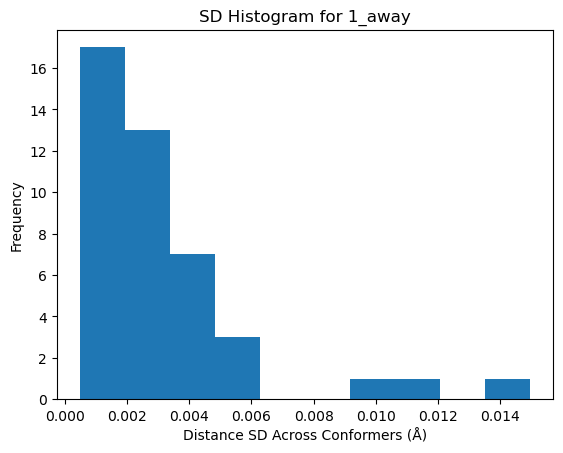

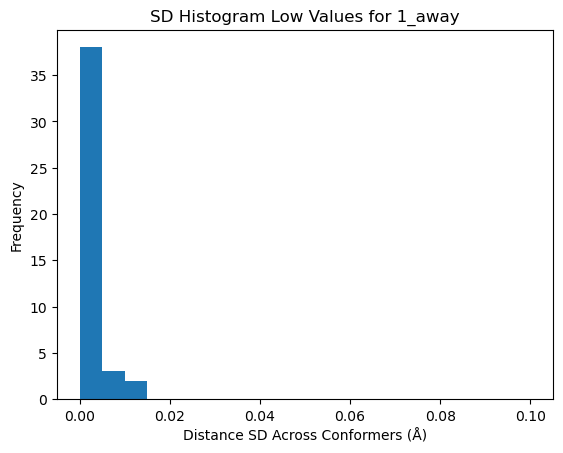

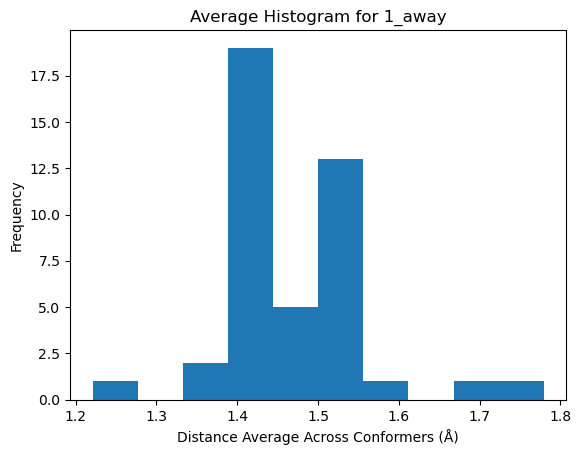

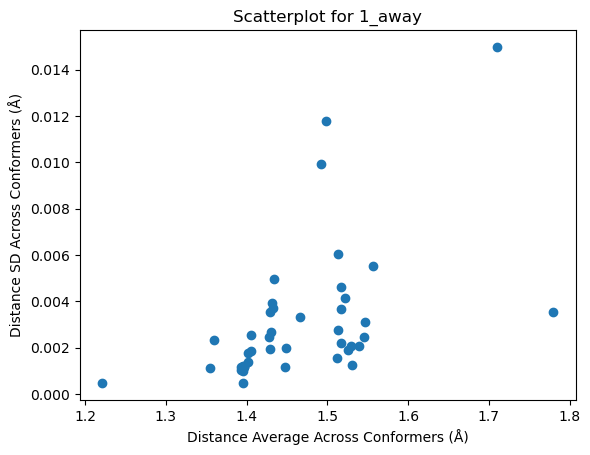

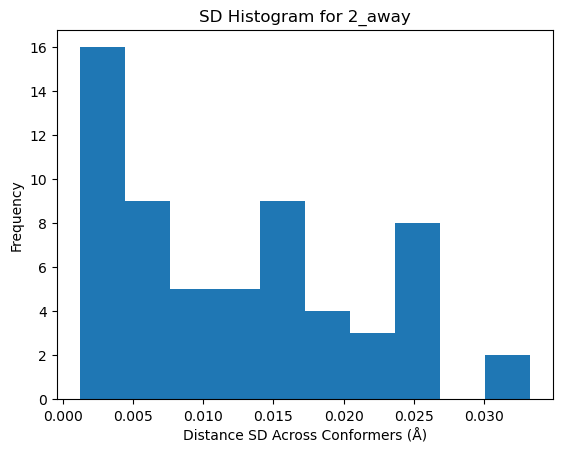

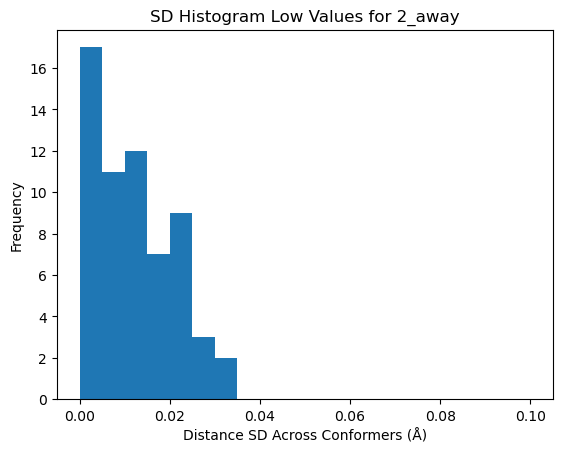

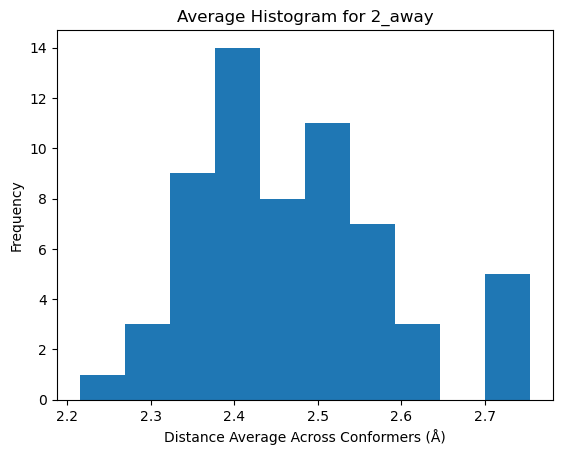

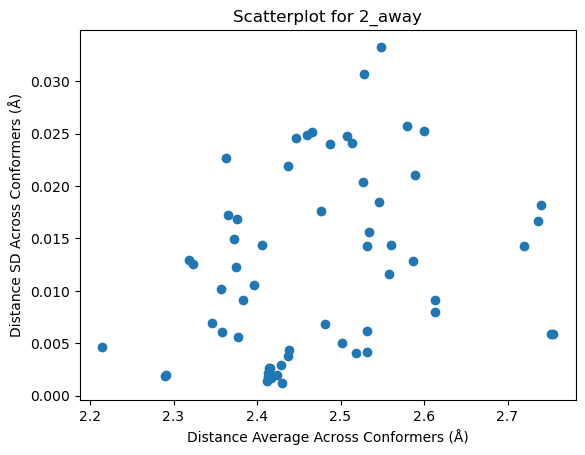

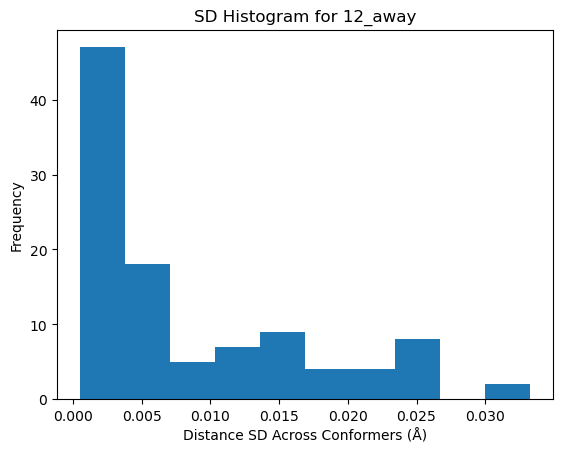

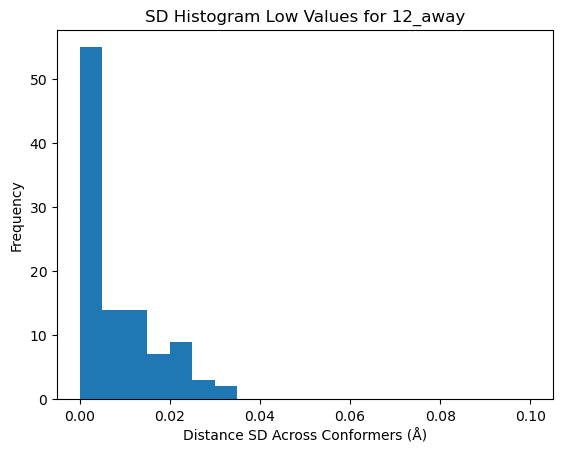

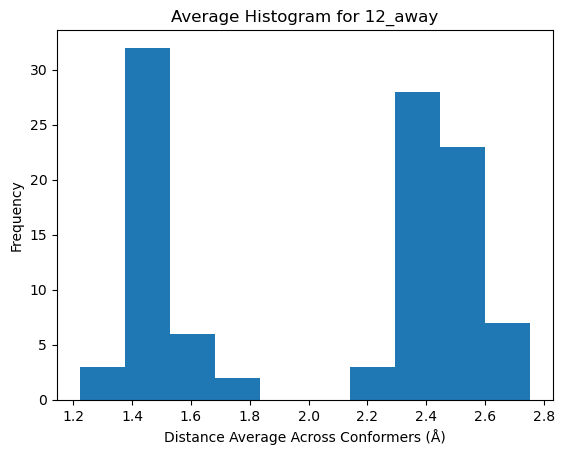

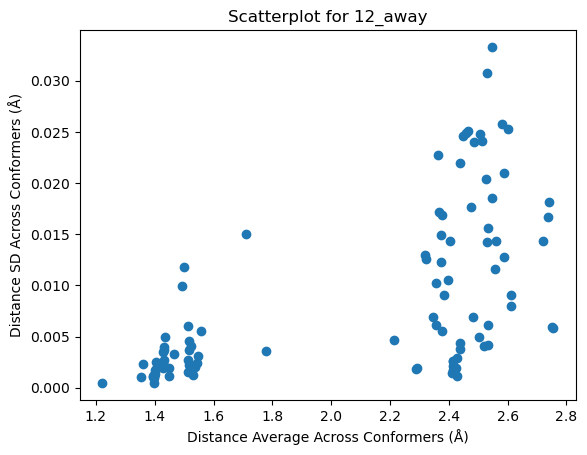

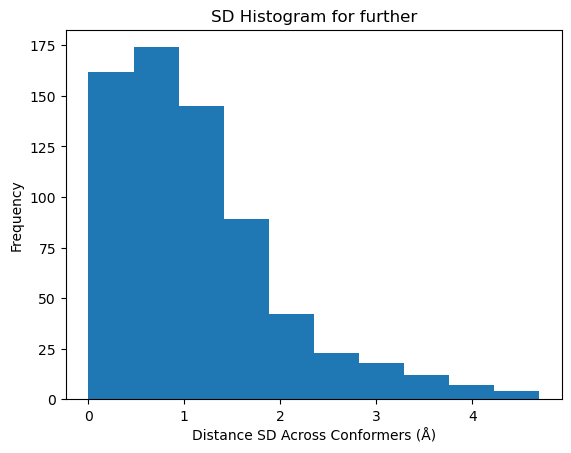

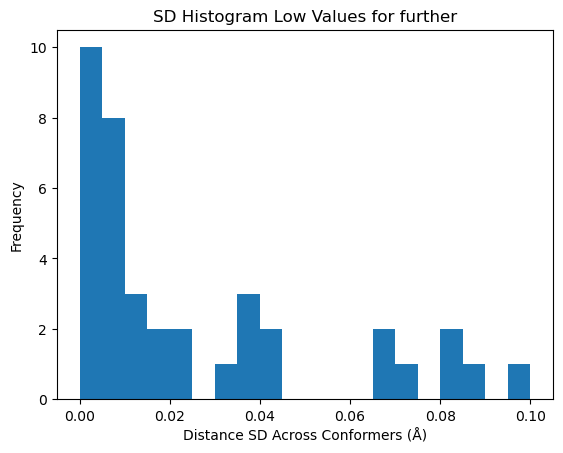

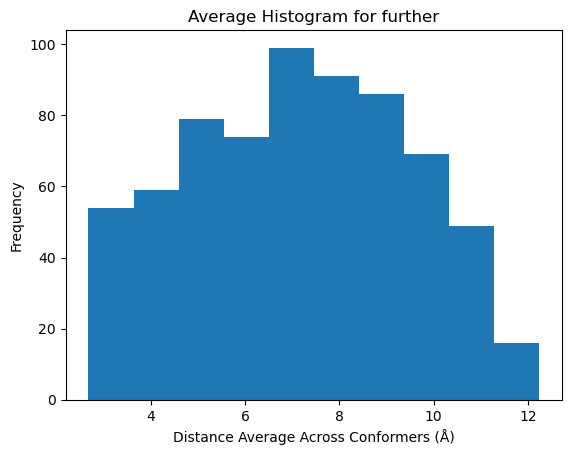

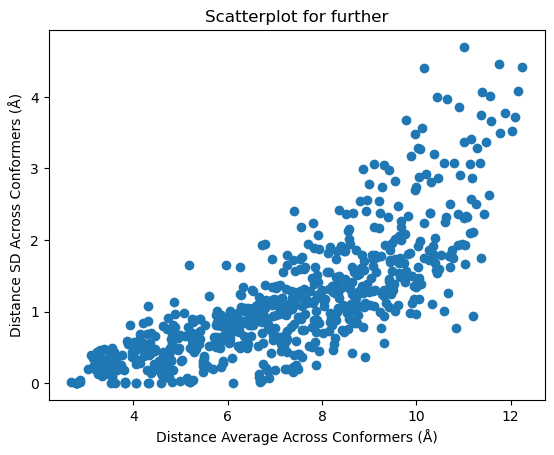

<Figure size 640x480 with 0 Axes>

In [62]:
#Pull sdf/mol2 and then smiles

count_of_d_2_below_cutoff = []
count_of_d_further_below_cutoff = []
sd_cutoff = 0.10

for pdb_name in name_info:

    #Copied below from https://github.com/gcorso/DiffDock/blob/main/datasets/pdbbind.py
    for file in os.listdir(os.path.join(pdbpath, pdb_name)):
        if file.endswith(".sdf") and 'rdkit' not in file:
            lig = read_molecule(os.path.join(pdbpath, pdb_name, file), remove_hs=False, sanitize=True)
            if lig is None and os.path.exists(os.path.join(pdbpath, pdb_name, file[:-4] + ".mol2")):  # read mol2 file if sdf file cannot be sanitized
                print('Using the .sdf file failed. We found a .mol2 file instead and are trying to use that.')
                lig = read_molecule(os.path.join(pdbpath, pdb_name, file[:-4] + ".mol2"), remove_hs=False, sanitize=True)

    count_d_2, count_d_over_2 = run_consensus_analysis(lig, sd_cutoff)
    count_of_d_2_below_cutoff.append(count_d_2)
    count_of_d_further_below_cutoff.append(count_d_over_2)

In [63]:
count_of_d_further_below_cutoff

[38]

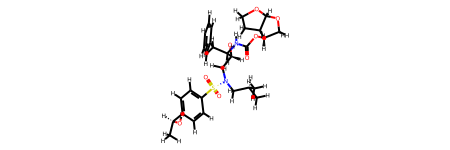

In [5]:
lig

In [25]:
#Ref https://www.rdkit.org/docs/GettingStartedInPython.html
heavy_atom_list = []
heavy_atom_bonds = []

#Record all heavy atoms
for a in lig.GetAtoms():
    if a.GetAtomicNum() > 1:
        print(f"found atom {a.GetSymbol()}")
        heavy_atom_list.append(a.GetIdx())
    else:
        print("found H")

#Find each bond, record
for b in lig.GetBonds():
    at1 = b.GetBeginAtomIdx()
    at2 = b.GetEndAtomIdx()
    at1_an = lig.GetAtomWithIdx(at1).GetAtomicNum()
    at2_an = lig.GetAtomWithIdx(at2).GetAtomicNum()
    if at1_an == 1 or at2_an == 1:
        continue
    else:
        print("heavy atom bond")
        print(f"{at1} element {at1_an}")
        print(f"{at2} element {at2_an}")
        print("----")
        heavy_atom_bonds.append([at1, at2])
    #print([x.GetAtomicNum() for x in at.GetNeighbors()])

found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom C
found atom N
found atom N
found atom O
found atom O
found atom O
found atom O
found atom O
found atom O
found atom O
found atom O
found atom S
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
found H
heavy atom bond
0 element 6
13 element 6
----
heavy atom bond
29 element 7
0 element 6
----
heavy atom bond
1 element 6
2 element 6
----
heavy atom bond
1 eleme

In [34]:
#keys- atoms, values- neighbors 1 and 2 away
atom_neighbor_dict_12_away = {}
atom_neighbor_dict_1_away = {}
atom_neighbor_dict_2_away = {}

#Initialize and 1st shell neighbors
for a in heavy_atom_list:
    atom_neighbor_dict_1_away[a] = []
    
    #Add all 1 away
    for b in heavy_atom_bonds:
        print(b)
        if b[0] == a:
            atom_neighbor_dict_1_away[a].append(b[1])
        if b[1] == a:
            atom_neighbor_dict_1_away[a].append(b[0])
print("1 away")
print(atom_neighbor_dict)

#2 away neighbors
for a2 in heavy_atom_list:
    atom_neighbor_dict_2_away[a2] = []
    
    #Now add in the neighbor's neighbors
    #All 1 away from the neighbor
    #Filter for a2 though
    for b2 in heavy_atom_bonds:
        #print(b2)
        if b2[0] == a2:
            neighbor_neighbor_not_a2 = [i for i in atom_neighbor_dict_1_away[b2[1]] if i is not a2]
            atom_neighbor_dict_2_away[a2] += neighbor_neighbor_not_a2
        if b2[1] == a2:
            neighbor_neighbor_not_a2 = [i for i in atom_neighbor_dict_1_away[b2[0]] if i is not a2]
            atom_neighbor_dict_2_away[a2] += neighbor_neighbor_not_a2

print("2 away")
print(atom_neighbor_dict_2_away)

#Combine 1 and 2 away
for a12 in heavy_atom_list:
    atom_neighbor_dict_12_away[a12] = list(set(atom_neighbor_dict_1_away[a12] + atom_neighbor_dict_2_away[a12]))
    
print("1 and 2 away")
print(atom_neighbor_dict_12_away)

[0, 13]
[29, 0]
[1, 2]
[1, 3]
[35, 1]
[2, 36]
[3, 4]
[3, 16]
[4, 17]
[6, 5]
[10, 5]
[5, 26]
[7, 6]
[8, 7]
[8, 9]
[39, 8]
[9, 10]
[11, 12]
[29, 11]
[12, 27]
[12, 28]
[13, 14]
[13, 33]
[14, 18]
[14, 30]
[30, 15]
[15, 34]
[15, 35]
[16, 36]
[16, 37]
[37, 17]
[18, 19]
[19, 20]
[19, 24]
[20, 21]
[21, 22]
[23, 22]
[24, 23]
[26, 25]
[26, 38]
[29, 39]
[39, 31]
[39, 32]
[0, 13]
[29, 0]
[1, 2]
[1, 3]
[35, 1]
[2, 36]
[3, 4]
[3, 16]
[4, 17]
[6, 5]
[10, 5]
[5, 26]
[7, 6]
[8, 7]
[8, 9]
[39, 8]
[9, 10]
[11, 12]
[29, 11]
[12, 27]
[12, 28]
[13, 14]
[13, 33]
[14, 18]
[14, 30]
[30, 15]
[15, 34]
[15, 35]
[16, 36]
[16, 37]
[37, 17]
[18, 19]
[19, 20]
[19, 24]
[20, 21]
[21, 22]
[23, 22]
[24, 23]
[26, 25]
[26, 38]
[29, 39]
[39, 31]
[39, 32]
[0, 13]
[29, 0]
[1, 2]
[1, 3]
[35, 1]
[2, 36]
[3, 4]
[3, 16]
[4, 17]
[6, 5]
[10, 5]
[5, 26]
[7, 6]
[8, 7]
[8, 9]
[39, 8]
[9, 10]
[11, 12]
[29, 11]
[12, 27]
[12, 28]
[13, 14]
[13, 33]
[14, 18]
[14, 30]
[30, 15]
[15, 34]
[15, 35]
[16, 36]
[16, 37]
[37, 17]
[18, 19]
[19, 20]
[

new conf
0 13
[]
0 29
[]
1 2
[]
1 3
[]
1 35
[]
2 36
[]
3 4
[]
3 16
[]
4 17
[]
5 6
[]
5 10
[]
5 26
[]
6 7
[]
7 8
[]
8 9
[]
8 39
[]
9 10
[]
11 12
[]
11 29
[]
12 27
[]
12 28
[]
13 14
[]
13 33
[]
14 18
[]
14 30
[]
15 30
[]
15 34
[]
15 35
[]
16 36
[]
16 37
[]
17 37
[]
18 19
[]
19 20
[]
19 24
[]
20 21
[]
21 22
[]
22 23
[]
23 24
[]
25 26
[]
26 38
[]
29 39
[]
31 39
[]
32 39
[]
new conf
0 13
[1.5453965110147878]
0 29
[1.5010941750961702]
1 2
[1.5184957684791835]
1 3
[1.5140142976986581]
1 35
[1.426620579374828]
2 36
[1.4314806075308841]
3 4
[1.5251705178040074]
3 16
[1.5175771952966821]
4 17
[1.5152701878222647]
5 6
[1.4055129165569153]
5 10
[1.4055135745415355]
5 26
[1.5135777625852878]
6 7
[1.3954770845124922]
7 8
[1.3970294745173295]
8 9
[1.3961498829004082]
8 39
[1.7693439239382176]
9 10
[1.3982890928294485]
11 12
[1.538138056277275]
11 29
[1.4930083327425645]
12 27
[1.5314432522868728]
12 28
[1.5278283534989778]
13 14
[1.553542320531964]
13 33
[1.438501767372148]
14 18
[1.5436541423724115]

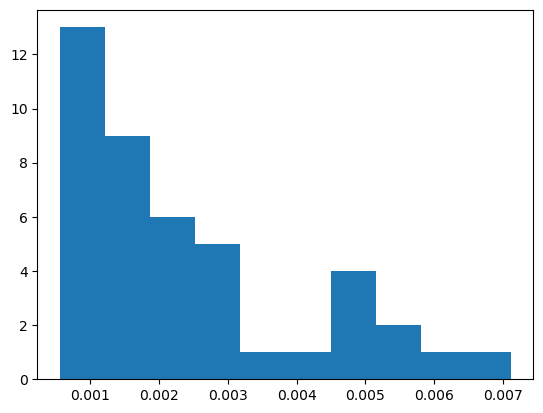

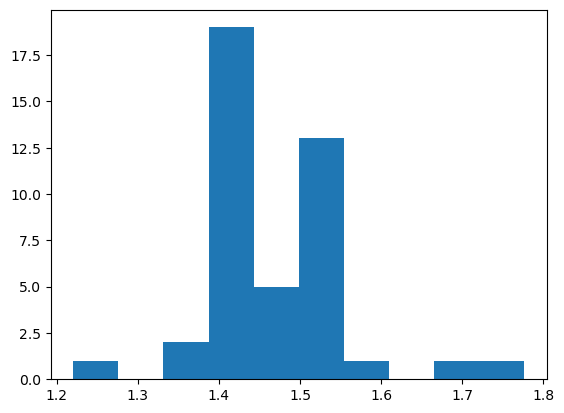

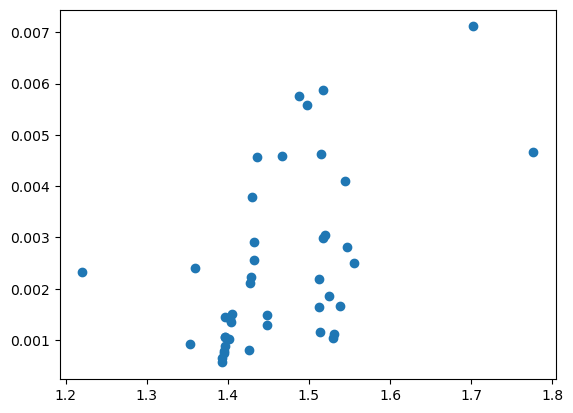

<Figure size 640x480 with 0 Axes>

In [52]:
away_1_dists = []
away_1_dist_dict = {}

#keys atom pairs
#values distance list- one distance/conformer
for a1add in atom_neighbor_dict_1_away.keys():
    for a1addpair in atom_neighbor_dict_1_away[a1add]:
        away_1_dist_dict[tuple(sorted([a1add, a1addpair]))] = []
        
#print(away_1_dist_dict)

#Iterate over conformers
for conf in conformers:
    #for each conformer refresh so do not duplicate e.g. (1,2) and then (2,1)
    already_checked = []
    print("new conf")
    
    #Each heavy atom
    for away1 in atom_neighbor_dict_1_away.keys():
        
        #Each heavy atom partner of interest
        for away1pair in atom_neighbor_dict_1_away[away1]:
            
            #Make sure not already found
            if sorted([away1, away1pair]) not in already_checked:
                already_checked.append([away1, away1pair])
                
                #Coordinate find, distance find
                print(f"{away1} {away1pair}")
                away1coords = conf[away1]
                away2coords = conf[away1pair]
                #Ref https://stackoverflow.com/questions/1401712/how-can-the-euclidean-distance-be-calculated-with-numpy
                dist = np.linalg.norm(away1coords - away2coords)
                
                #Add to list and dictionary
                away_1_dists.append(dist)
                print(away_1_dist_dict[tuple(sorted([away1, away1pair]))])
                key_update = tuple(sorted([away1, away1pair]))
                away_1_dist_dict[key_update].append(dist)

avg_list = []
sd_list = []
for paircalc in away_1_dist_dict.keys():
    dist_analyze = away_1_dist_dict[paircalc]
    avg_list.append(np.average(dist_analyze))
    sd_list.append(np.std(dist_analyze, ddof = 1))
    
plt.hist(sd_list)
plt.show()
plt.cla()
plt.clf()
plt.hist(avg_list)
plt.show()
plt.cla()
plt.clf()
plt.scatter(avg_list, sd_list)
plt.show()
plt.cla()
plt.clf()

In [10]:
num_conf = 10
#Copied from https://github.com/HannesStark/EquiBind/blob/41bd00fd6801b95d2cf6c4d300cd76ae5e6dab5e/commons/process_mols.py#L447
ps = AllChem.ETKDGv2()
ids = rdDistGeom.EmbedMultipleConfs(lig, num_conf, ps)
AllChem.MMFFOptimizeMoleculeConfs(lig)
conformers = []
for i in range(num_conf):
    conformers.append(lig.GetConformer(i).GetPositions())
print(conformers[0])
print(len(conformers))

[ 0.10994914  0.89739998 -1.0389876 ]
10


In [9]:
#ref https://iwatobipen.wordpress.com/2021/01/31/generate-conformers-script-with-rdkit-rdkit-chemoinformatics/
param = rdDistGeom.ETKDGv2()
#param.pruneRmsThresh = prunermsthresh
cids = rdDistGeom.EmbedMultipleConfs(lig, 20, param)
mp = AllChem.MMFFGetMoleculeProperties(lig, mmffVariant='MMFF94s')
AllChem.MMFFOptimizeMoleculeConfs(lig, numThreads=0, mmffVariant='MMFF94s')

[(1, -2.186651820492152),
 (1, -1.7213061832853302),
 (1, -7.565614995064319),
 (1, -0.798321176798396),
 (1, -3.7722802682662024),
 (1, -10.195510274288932),
 (1, -5.497278120553453),
 (1, -7.321390542226727),
 (1, -0.8599793657862751),
 (1, -7.9214133227418895),
 (1, -0.9256121332081593),
 (1, -3.2856425812912624),
 (1, -8.23726995342548),
 (1, -12.95859292039647),
 (1, -8.143452374521324),
 (1, -4.743661016713163),
 (1, 1.8467775921926073),
 (1, -4.783701327530315),
 (1, 6.184672383737393),
 (1, -6.47346315426011)]

In [12]:
cids[1]

1

In [22]:
#Ref https://github.com/gcorso/DiffDock/blob/main/datasets/process_mols.py copied
#Ref https://greglandrum.github.io/rdkit-blog/posts/2023-02-04-working-with-conformers.html copied
for i in range(20):
    #mol_rdkit = copy.deepcopy(lig)

    #mol_rdkit.RemoveAllConformers()
    #mol_rdkit = AllChem.AddHs(mol_rdkit)
    #generate_conformer(mol_rdkit)
    #if remove_hs:
    #    mol_rdkit = RemoveHs(mol_rdkit, sanitize=True)
    #mol = copy.deepcopy(mol_maybe_noh)
    #if rotable_bonds:
    #    optimize_rotatable_bonds(mol_rdkit, mol, rotable_bonds, popsize=popsize, maxiter=maxiter)
    #mol.AddConformer(mol_rdkit.GetConformer())
    #rms_list = []
    #AllChem.AlignMolConformers(mol, RMSlist=rms_list)
    #mol_rdkit.RemoveAllConformers()
    #mol_rdkit.AddConformer(lig.GetConformers()[i])
    print(lig.GetConformers()[i].GetPositions())
    print("--------")

[[ 1.63627453 -0.97936819  0.25551423]
 [-4.48145807  2.79093107 -0.37433626]
 [-5.03562985  3.7373107  -1.42373394]
 [-5.72045761  2.01685903  0.0308821 ]
 [-6.15121888  0.87285091 -0.87537069]
 [ 6.46938689  1.18271707 -0.51195973]
 [ 6.37795129  1.00177838  0.87860461]
 [ 5.14176324  1.05171012  1.52593661]
 [ 3.97927581  1.24633427  0.7772535 ]
 [ 4.0528356   1.45855945 -0.6024938 ]
 [ 5.29383996  1.41597266 -1.24319261]
 [ 2.60010881 -1.24022177  2.53506518]
 [ 1.73123552 -1.7134519   3.71290299]
 [ 0.52586993 -0.36498687 -0.61949612]
 [-0.88106377 -0.3821909   0.03718008]
 [-2.75647857  1.24182631 -0.01142603]
 [-6.82377749  3.04952999 -0.11354844]
 [-7.4436721   1.34463215 -1.51007816]
 [-1.53333354 -1.78059268  0.19545359]
 [-2.1050074  -2.42736977 -1.04856554]
 [-3.39067643 -2.09042254 -1.49504366]
 [-3.93311028 -2.68633269 -2.63352729]
 [-3.19634967 -3.63453078 -3.33921241]
 [-1.92011556 -3.98630514 -2.90290964]
 [-1.37941514 -3.39049441 -1.7618069 ]
 [ 8.11510961 -0.34555141

AttributeError: 'Mol' object has no attribute 'atoms'

In [53]:
np.linspace(0,2,11)

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ])